In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ideas

* Correlate `elapsed_time` between first case and `mandate_when` with `cases_per_million`
* Correlate `mask_mandate` with `pos_cases_per_tests`

# Data Import and Clean

## Mask Data

In [2]:
df_mask = pd.read_csv("mask-use/mask-use-by-county.csv")
df_mask.columns = df_mask.columns.str.lower()
df_mask.head()

,countyfp,never,rarely,sometimes,frequently,always
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


In [3]:
df_mask.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   countyfp    3142 non-null   int64  
 1   never       3142 non-null   float64
 2   rarely      3142 non-null   float64
 3   sometimes   3142 non-null   float64
 4   frequently  3142 non-null   float64
 5   always      3142 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 147.4 KB


In [4]:
df_county = pd.read_csv("data/us-counties.csv",parse_dates=['date'])
df_county.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [5]:
df_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437519 entries, 0 to 437518
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    437519 non-null  datetime64[ns]
 1   county  437519 non-null  object        
 2   state   437519 non-null  object        
 3   fips    433275 non-null  float64       
 4   cases   437519 non-null  int64         
 5   deaths  437519 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 20.0+ MB


In [6]:
df = df_mask.merge(df_county,left_on='countyfp',right_on='fips')
df.describe()

,countyfp,never,rarely,sometimes,frequently,always,fips,cases,deaths
count,424816.000000,424816.000000,424816.000000,424816.000000,424816.000000,424816.000000,424816.000000,424816.000000,424816.000000
mean,30221.058647,0.076886,0.080083,0.119139,0.206026,0.517856,30221.058647,679.469919,26.380845
std,15284.744500,0.057085,0.053994,0.057835,0.062632,0.150850,15284.744500,3779.123012,154.181579
min,1001.000000,0.000000,0.000000,0.001000,0.029000,0.115000,1001.000000,1.000000,0.000000
25%,18119.000000,0.032000,0.038000,0.076000,0.162000,0.404000,18119.000000,10.000000,0.000000
50%,29103.000000,0.066000,0.071000,0.113000,0.202000,0.507000,29103.000000,50.000000,1.000000
75%,45063.000000,0.108000,0.111000,0.153000,0.245000,0.626000,45063.000000,247.000000,6.000000
max,56045.000000,0.432000,0.384000,0.422000,0.549000,0.889000,56045.000000,220762.000000,5245.000000


## Population Data

In [7]:
statepop_raw = pd.read_csv('data/statepop.csv')
statepop_raw.columns = statepop_raw.columns.str.lower()

In [8]:
region_mask = {
    1:'Northeast',
    2:'Midwest',
    3:'South',
    4:'West'
}

In [9]:
statepop = statepop_raw[statepop_raw['state']!=0][['name','popestimate2019','region']].reset_index(drop=True)

## Merge the Two

In [10]:
def list_diff(list1,list2):
    '''
    Finds what is missing from, or what is different between, the two lists.
    
    return
    ------
    list_difference: list
    '''
    list_difference = {}
    
    if len(list1) > len(list2):
        bigger = list1
        smaller = list2
    else:
        bigger = list2
        smaller = list1
        
    for item in bigger:
        if item not in smaller:
            list_difference[item] = f'missing from smaller list'

    return list_difference

In [11]:
states_names_states_df = list(df['state'].unique())
states_names_pop_df = list(statepop['name'].unique())

In [12]:
list_diff(states_names_states_df, states_names_pop_df)

{'Puerto Rico': 'missing from smaller list'}

Only PR is not in our populations list

In [13]:
df = df.merge(statepop, left_on='state',right_on='name')

In [14]:
df['region'] = df['region'].astype(int)

In [15]:
df['cases_per_million'] = (df['cases']/df['popestimate2019']) * 1000000
df['cases_per_hthousand'] = (df['cases']/df['popestimate2019']) * 100000
df['cases_per_thousand'] = (df['cases']/df['popestimate2019']) * 1000
df['cases_per_hundred'] = (df['cases']/df['popestimate2019']) * 100

In [16]:
df['region'] = df['region'].map(region_mask)

In [17]:
df.head()

,countyfp,never,rarely,sometimes,frequently,always,date,county,state,fips,cases,deaths,name,popestimate2019,region,cases_per_million,cases_per_thousand,cases_per_hundred
0,1001,0.053,0.074,0.134,0.295,0.444,2020-03-24,Autauga,Alabama,1001.0,1,0,Alabama,4903185,South,0.203949,0.000204,0.000020
1,1001,0.053,0.074,0.134,0.295,0.444,2020-03-25,Autauga,Alabama,1001.0,4,0,Alabama,4903185,South,0.815796,0.000816,0.000082
2,1001,0.053,0.074,0.134,0.295,0.444,2020-03-26,Autauga,Alabama,1001.0,6,0,Alabama,4903185,South,1.223694,0.001224,0.000122
3,1001,0.053,0.074,0.134,0.295,0.444,2020-03-27,Autauga,Alabama,1001.0,6,0,Alabama,4903185,South,1.223694,0.001224,0.000122
4,1001,0.053,0.074,0.134,0.295,0.444,2020-03-28,Autauga,Alabama,1001.0,6,0,Alabama,4903185,South,1.223694,0.001224,0.000122


# Mask Use

## NYT Methodology

> To transform raw survey responses into county-level estimates, the survey data was weighted by age and gender, and survey respondents’ locations were approximated from their ZIP codes. Then estimates of mask-wearing were made for each census tract by taking a weighted average of the 200 nearest responses, with closer responses getting more weight in the average. These tract-level estimates were then rolled up to the county level according to each tract’s total population.
> 
> By rolling the estimates up to counties, it reduces a lot of the random noise that is seen at the tract level. In addition, the shapes in the map are constructed from census tracts that have been merged together — this helps in displaying a detailed map, but is less useful than county-level in analyzing the data.

In [18]:
df['mask_wearer'] = (df['always'] + df['frequently'] + df['sometimes'])*100
df['non_wearer'] = (df['rarely'] + df['never'])*100

In [19]:
df.groupby('state').mean()[['mask_wearer','non_wearer','cases','deaths']].sort_values('mask_wearer')

,mask_wearer,non_wearer,cases,deaths
state,,,,
North Dakota,65.702535,34.295407,70.502305,1.369773
Montana,69.134523,30.866823,37.224498,0.694558
Wyoming,69.142287,30.864907,55.665410,0.649073
South Dakota,73.833800,26.176846,94.565447,1.241183
Idaho,74.507575,25.492772,196.239591,2.566500
Missouri,74.580106,25.416128,175.297344,6.808081
Nebraska,76.672359,23.328473,202.583642,2.707357
Kansas,77.557025,22.443520,145.332953,2.505129
Minnesota,77.857824,22.130708,317.657917,11.570506


# Masks Per State

In [20]:
df_graph = df[(df['state']=='Ohio')|
              (df['state']=='New Hampshire')|
              (df['state']=='Texas')|
              (df['state']=='Massachusetts')|
              (df['state']=='California')|
              (df['state']=='Florida')]

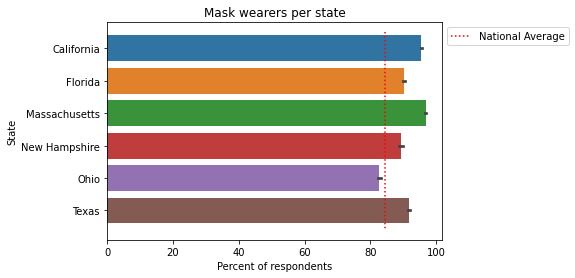

In [21]:
g = sns.barplot(y='state',x='mask_wearer',data=df_graph[df_graph['date'] <'20200401'], orient='h')
plt.title('Mask wearers per state')
#plt.text(0.5,0.05,'"Always","frequently",or "sometimes" wearing masks outside of the home')
plt.xlabel('Percent of respondents')
plt.ylabel('State')
plt.vlines(df['mask_wearer'].mean(),-0.5,5.6,color='red',linestyles='dotted',label = 'National Average')
plt.legend(bbox_to_anchor=(1,1))
#plt.savefig('mask_wearers.png',dpi=300,bbox_inches='tight')

In [22]:
df['pop_in_mill'] = df['popestimate2019']/1000000

In [23]:
df.describe()[['pop_in_mill']]

,pop_in_mill
count,424816.000000
mean,9.099252
std,8.580857
min,0.578759
25%,3.155070
50%,6.137428
75%,10.617423
max,39.512223


<AxesSubplot:xlabel='pop_in_mill'>

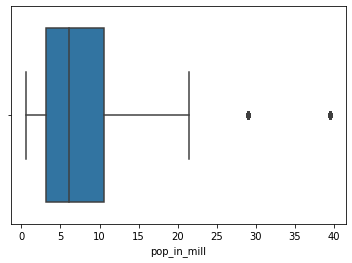

In [24]:
sns.boxplot(df['pop_in_mill'])

The populations of each state differ, but the raw numbers are hard to interpret. For this reason each state is categorized into size.

Based on this boxplot the following seems reasonable:
* `small`: less than 2 million
* `medium`: 2 million - 10 million
* `large`: greater than 10 million

In [38]:
def state_size_cat(cell):
    '''
    Categorizes each state by their size
    '''
    if pd.isnull(cell):
        return 'no data'
    elif cell < 2000000:
        return 'small'
    elif cell > 10000000:
        return 'large'
    elif (cell > 2000000) & (cell < 10000000):
        return 'medium'
    else:
        return 'no data'

In [39]:
df['state_size'] = df['popestimate2019'].apply(state_size_cat)

In [40]:
df.groupby('state_size').mean()[['pop_in_mill','cases_per_million','mask_wearer','non_wearer',]]

,pop_in_mill,cases_per_million,mask_wearer,non_wearer
state_size,,,,
large,18.808520,58.449300,88.233109,11.765158
medium,5.445992,102.521619,83.729452,16.269276
small,1.286041,170.259263,77.221903,22.780549


In [41]:
df.groupby('region').mean()[['pop_in_mill','cases_per_million','mask_wearer','non_wearer',]]

,pop_in_mill,cases_per_million,mask_wearer,non_wearer
region,,,,
Midwest,6.229409,65.656741,79.390814,20.609427
Northeast,10.992251,308.635440,93.566951,6.432644
South,10.778878,78.596641,85.705954,14.292573
West,9.134710,121.371008,86.083880,13.913928


In [47]:
state_order = ['small','medium','large']

Text(0, 0.5, 'Percent Rarely or Never')

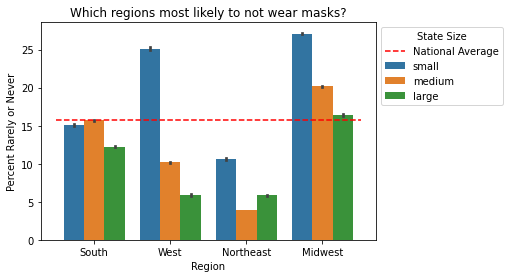

In [48]:
g = sns.barplot(x='region',y='non_wearer',hue='state_size',data=df,hue_order=state_order)
plt.hlines(df['non_wearer'].mean(),-0.5,3.5,linestyles='--',color='red',label='National Average')
g.legend(bbox_to_anchor=(1,1),title='State Size')
plt.title('Which regions most likely to not wear masks?')
plt.xlabel('Region')
plt.ylabel('Percent Rarely or Never')

/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  


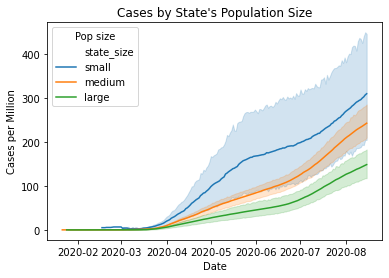

In [51]:
sns.lineplot(x='date',y='cases_per_million',hue='state_size',data=df, hue_order = state_order)
plt.title("Cases by State's Population Size")
plt.xlabel('Date')
plt.ylabel('Cases per Million')
plt.legend(title='Pop size')
plt.savefig('cases_per_pop.png',dpi=300,bbox_layout='tight')

TypeError: xlabel() missing 1 required positional argument: 'xlabel'

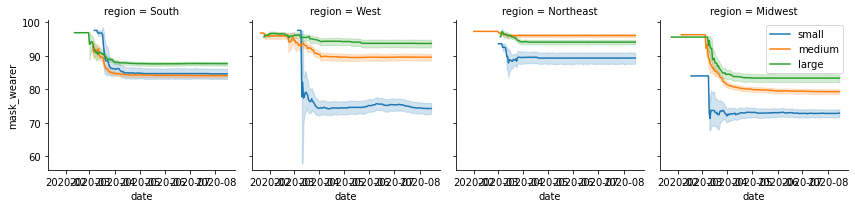

In [56]:
g = sns.FacetGrid(df, col='region', hue='state_size',hue_order=state_order)
g.map(sns.lineplot,'date','mask_wearer')
plt.legend()

# Masks Over Time

(70.0, 100.0)

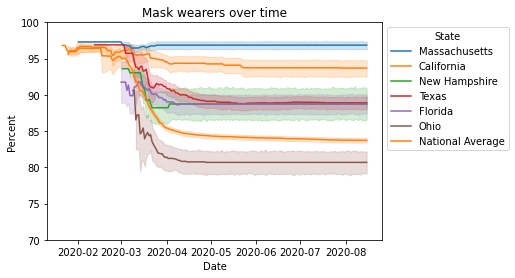

In [72]:
g = sns.lineplot(x='date',y='mask_wearer',hue='state',data=df_graph, 
                 hue_order=['Massachusetts','California','New Hampshire', 'Texas','Florida','Ohio'])
h = sns.lineplot(x='date',y='mask_wearer',data=df,label='National Average')

handles, labels = g.get_legend_handles_labels()
g.legend(bbox_to_anchor=(1,1),title='State',handles=handles[1:], labels=labels[1:])

plt.title('Mask wearers over time')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.ylim(70,100)

# plt.savefig('line_states_mask2.png',dpi=300,bbox_inches='tight')

In [75]:
df_graph = df[
              (df['state']=='Ohio') |
              (df['state']=='Massachusetts') |
              (df['state']=='Texas')
             ]

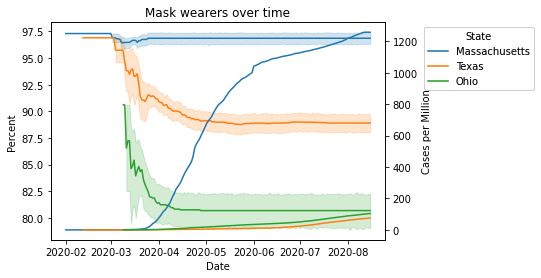

In [91]:
g = sns.lineplot(x='date',y='mask_wearer',hue='state',data=df_graph, 
                 hue_order=['Massachusetts','Texas','Ohio'])
handles, labels = g.get_legend_handles_labels()
g.legend(bbox_to_anchor=(1.1,1),title='State',handles=handles[1:], labels=labels[1:])

plt.title('Mask wearers over time')
plt.xlabel('Date')
plt.ylabel('Percent')

ax2 = plt.twinx()
h = sns.lineplot(x='date',y='cases_per_million',data=df_graph,ax=ax2, 
                 ci=None,hue='state', hue_order=['Massachusetts','Texas','Ohio'])
plt.ylabel('Cases per Million')
handles, labels = h.get_legend_handles_labels()
h.legend(bbox_to_anchor=(1.1,1),title='State',handles=handles[1:], labels=labels[1:])

# plt.savefig('line_states_mask2.png',dpi=300,bbox_inches='tight')

__Takeaway:__ MA mask adherence stayed so high because their cases per million remained high

# Influence of Mask Mandates

* [Source 1](https://www.aarp.org/health/healthy-living/info-2020/states-mask-mandates-coronavirus.html)
* [Source 2](https://www.cnn.com/2020/06/19/us/states-face-mask-coronavirus-trnd/index.html)

Dataset collected from above sources. In situations when the date was different, the earliest date was taken. `Type` includes tags for description of mandate currently in effect.

In [92]:
df_mand = pd.read_excel('data/mask_mandates.xlsx',skiprows=2)
df_mand.columns = df_mand.columns.str.lower()

In [93]:
df_mand['type'] = df_mand['type'].str.lower()
df_mand['type_split'] = df_mand['type'].str.split(',')

In [94]:
df_mand.head()

,state,mandate,date,type,type_split
0,Alabama,Yes,2020-07-16,indoor and outdoor,[indoor and outdoor]
1,Alaska,No,NaT,NaN,NaN
2,Arizona,No,NaT,NaN,NaN
3,Arkansas,Yes,2020-07-20,children exempt,[children exempt]
4,California,Yes,2020-06-18,toddlers exempt,[toddlers exempt]


In [95]:
df_states = df.groupby(['state','date']).mean().reset_index()

In [96]:
df_states = df_states.merge(df_mand, on='state',suffixes=['','_mandate'])

In [116]:
df_states['state_size'] = df_states['popestimate2019'].map(state_size_cat)

In [117]:
df_graph_mand = df_states[(df_states['state']=='Ohio')|
              (df_states['state']=='New Hampshire')|
              (df_states['state']=='Texas')|
              (df_states['state']=='Massachusetts')|
              (df_states['state']=='California')|
              (df_states['state']=='Florida')]

In [118]:
def who_exempt(cell):
    if pd.isna(cell):
        return 'no mandate'
    elif 'children' in cell:
        return 'child exempt'
    elif 'toddler' in cell:
        return 'toddler exempt'
    else:
        return 'no exemptions'

In [119]:
df_states['children_toddlers_none'] = df_states['type'].apply(who_exempt)

In [120]:
df_states['month_mandate'] = df_states['date_mandate'].dt.month
df_states['month_mandate'] = df_states['month_mandate'].fillna('no mandate')

In [121]:
import datetime as dt

In [122]:
df_states['date_mandate'][0] < dt.datetime.strptime('20200718','%Y%m%d')

True

In [123]:
def mandate_when(x):
    if pd.isna(x):
        return 'No Mandate'
    elif x<dt.datetime.strptime('20200515','%Y%m%d'):
        return 'Before May 15'
    elif x>dt.datetime.strptime('20200715','%Y%m%d'):
        return 'After Jul 15'
    else:
        return 'In Between'

In [124]:
df_states['mandate_when'] = df_states['date_mandate'].apply(mandate_when)

Text(0, 0.5, 'Percent who wear masks')

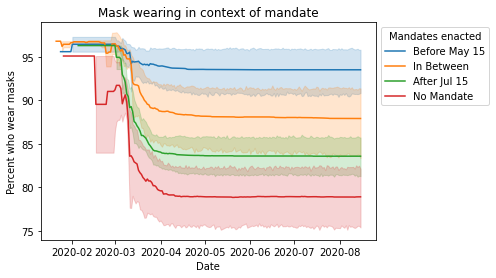

In [125]:
m = sns.lineplot(x='date',y='mask_wearer',hue='mandate_when',data=df_states,
             hue_order=['Before May 15','In Between','After Jul 15','No Mandate'])

handles, labels = m.get_legend_handles_labels()
m.legend(bbox_to_anchor=(1,1),title='Mandates enacted',handles=handles[1:], labels=labels[1:])

plt.title('Mask wearing in context of mandate')
plt.xlabel('Date')
plt.ylabel('Percent who wear masks')

__Interpretation:__ While there was a drop in mask wearing across the board, states who gave mandatory mask orders earlier were more likely to be wearing masks currently.

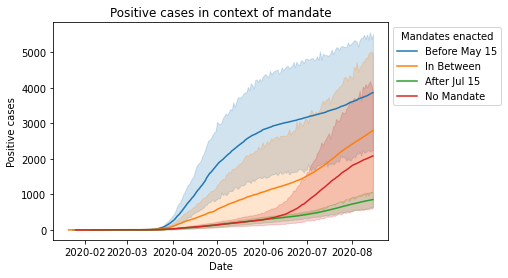

In [126]:
m = sns.lineplot(x='date',y='cases',hue='mandate_when',data=df_states,
             hue_order=['Before May 15','In Between','After Jul 15','No Mandate'])

handles, labels = m.get_legend_handles_labels()
m.legend(bbox_to_anchor=(1,1),title='Mandates enacted',handles=handles[1:], labels=labels[1:])

plt.title('Positive cases in context of mandate')
plt.xlabel('Date')
plt.ylabel('Positive cases')

plt.savefig('cases_madate.png', dpi=300, bbox_inches='tight')

__Interpretation:__ Mask mandated seem to have been enacted as reactionary, not preventative, measures. Mandates went into effect around the time that cases increased.

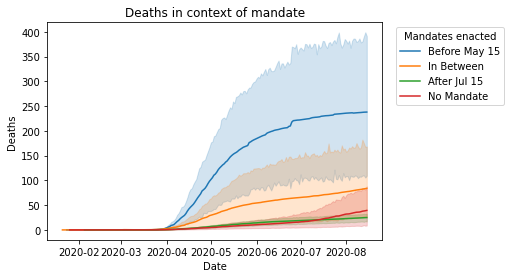

In [127]:
a = sns.lineplot(x='date',y='deaths',hue='mandate_when',data=df_states,
             hue_order=['Before May 15','In Between','After Jul 15','No Mandate'])

plt.title('Deaths in context of mandate')
plt.xlabel('Date')
plt.ylabel('Deaths')

handles, labels = a.get_legend_handles_labels()
a.legend(bbox_to_anchor=(1.38,1),title='Mandates enacted',handles=handles[1:], labels=labels[1:])

#plt.savefig('deaths_mandate.png', dpi=300, bbox_inches='tight')

__Interpretation:__ Mandates went into effect around the time that deaths increased.

Text(0, 0.5, 'Positive cases per million')

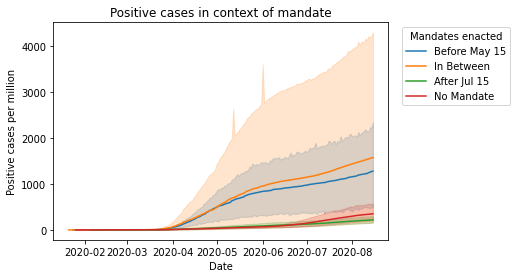

In [128]:
o = sns.lineplot(x='date',y='cases_per_million',hue='mandate_when',data=df_states,
             hue_order=['Before May 15','In Between','After Jul 15','No Mandate'])

handles, labels = o.get_legend_handles_labels()
o.legend(bbox_to_anchor=(1.38,1),title='Mandates enacted',handles=handles[1:], labels=labels[1:])

plt.title('Positive cases in context of mandate')
plt.xlabel('Date')
plt.ylabel('Positive cases per million')

# plt.savefig('cases_madate.png', dpi=300, bbox_inches='tight')

In [158]:
month_map = {
    1:'Jan',
    2:'Feb',
    3:'March',
    4:'April',
    5:'May',
    6:'June',
    7:'July',
    8:'Aug',
    9:'Sept',
    10:'Oct',
    11:'Nov',
    12:'Dec'
}

In [167]:
df_states['month_case'] = df_states['date'].dt.month

In [169]:
df_states['month_case_name'] = df_states['month_case'].map(month_map)

In [183]:
df_cat_graph = df_states[df_states['month_case'] >= 7]

In [187]:
df_cat_graph = df_cat_graph.groupby('state').mean().reset_index()
df_cat_graph['state_size'] = df_cat_graph['popestimate2019'].map(state_size_cat)
df_cat_graph = df_cat_graph.merge(df_states[['state','mandate_when']],on='state')
df_cat_graph['month_case_name'] = df_cat_graph['month_case'].map(month_map)

Text(0.5, 0, 'Date of Mask Mandate')

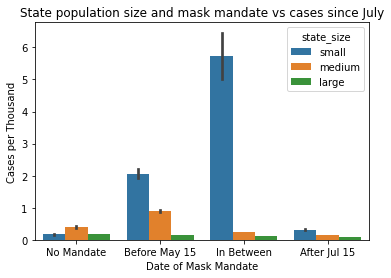

In [190]:
sns.barplot(x='mandate_when',y='cases_per_thousand',hue='state_size',
            data=df_cat_graph, hue_order=state_order, 
            order=[
                'No Mandate',
                'Before May 15',
                'In Between',
                'After Jul 15'
            ])
plt.title('State population size and mask mandate vs cases since July')
plt.ylabel('Cases per Thousand')
plt.xlabel('Date of Mask Mandate')

__Interpretation:__ More evidence that mandates were reactionary with some additional insights: 

* Those who enacted mandates before May have less cases per thousand than those who enacted mandates between May and Jul. 
* States who enacted mandates after Jul are doing better than either early mandaters, although this may be due to lack of data.
* States who have no mandate are overtaking the late adopters

NOTE: The `In Between` category might be too broad, given the ginormous confidence interval.